# MachineLearningWorkShop at UCSC
## Aug 18th - Learning with TESS Simulated data

### Last month we explored all type of learning algorithms with simulated light curves including:
- different planet sizes
- various period
- various white/red noise level
- different baseline

While the result looked promising, we need to extend our experiments to more realistic data. 

The data set we are using today is created from **SPyFFI**, an image simulator created by Zack Berta and his undergrad student Jacobi Kosiarok. 

The ingrediants included by **SPyFFI** are:
- catalogs of real stars
- somewhat realistic Camera and CCD effects, such as PRF variation, readout smear, resembling the TESS telescope
- spacecraft effects such as jitter/focusing change
- somewhat realistic noise buget
- transits and stellar variability (sine curves) draw from Kepler

**SPyFFI** out puts image time series like this:
![alt text](ds9.jpeg)

We process the images from 10 days of TESS observations with standard photometry pipeline, and create light curves for all the stars with TESS magnituded brighter than 14. 

For the region of sky we simulated (6 by 6 square degree), this results in 16279 stars. To make our tasks today simpler, we are going to work with only ~4000 stars.  

In [1]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:42: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/chelsea/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is

In [30]:
def make_ROC_curve(testY, predY, name):
    fig2 = plt.figure()
    ax= fig2.add_subplot(1,1,1)
    fpr, tpr, _ = roc_curve(testY, predY)
    ax.plot(fpr, tpr, label = name)
    ax.set_title(('ROC Curve for %s') % name)
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
def collect_lc_feature(idlist):
    LCfeature=np.zeros([len(idlist),481])
    count=0
    for i in idlist:
        #print i
        infile="LTFsmall/"+str(i)+".ltf"
        lc=np.loadtxt(infile)[:,1]
        LCfeature[count,0]=i
        LCfeature[count,1:]=lc
        count+=1
    return LCfeature
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['false positives', 'transits'], rotation=45)
    plt.yticks(tick_marks, ['false positives', 'transits'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def fit(model,name,data,cv=True):
    trainX,trainY,testX,testY,X,Y=data
    model.fit(trainX, trainY)
    predY = model.predict(testX)
    f1score = metrics.f1_score(testY, predY)
    cm = metrics.confusion_matrix(testY, predY)
    plot_confusion_matrix(cm)
    predY=model.predict_proba(testX)[:,1]
    rocscore = metrics.roc_auc_score(testY, predY)
    precision, recall, thresholds = metrics.precision_recall_curve(testY, predY)
    aucscore=metrics.auc(precision,recall,reorder=True)
    
    print "#####################################"
    print "Result using",model
    print "f1 score from train test split %f" % f1score
    print "roc score from train test split %f" % rocscore
    print "auc score from train test split %f" % aucscore
    if cv:
        #cvscore= cross_val_score(model, X, Y, cv = 5, scoring = 'f1')
        cvscore= cross_val_score(model, X, Y, cv = 5, scoring = 'roc_auc')
        print "f1 score from CV5 %f" % np.mean(cvscore)
    
    
    print cm
    make_ROC_curve(testY,predY,name)
    return

Let's first look at what the TESS light curves: 

TESS_simulated_10day_small.csv is the combined feature file.

TESS_simulated_lc_small.csv is the light curve file.

In [37]:
#df=pd.read_csv("TESS_simulated_10day_small.csv",index_col=0)
#df=pd.read_csv("TESS_simulateddata_combinedfeatures.csv",index_col=0)
df=pd.read_csv("TESSfield_19h_44d_combinedfeatures.csv")

In [38]:
#LCfeature=pd.DataFrame(collect_lc_feature(df['Ids']),columns=['Ids']+list(np.arange(480)))
#LCfeature.to_csv
#LCfeature=pd.read_csv("TESS_simulated_lc_small.csv",index_col=0)

In [39]:
#plt.plot(LCfeature.iloc[-1,1:],'.')

In [40]:
#plt.plot(LCfeature.iloc[0,:],'.')

The combined feature files contain features from Box Least Squal measurements, and 20 PCA components from the light curve. Later on hopefully we can explore how to create new features from the light curves.

Let's first examine the columns in the combined feature files: 

In [41]:
df.columns

Index([u'BLS_Period_1_0', u'BLS_Tc_1_0', u'BLS_SN_1_0', u'BLS_SR_1_0',
       u'BLS_SDE_1_0', u'BLS_Depth_1_0', u'BLS_Qtran_1_0', u'BLS_Qingress_1_0',
       u'BLS_OOTmag_1_0', u'BLS_i1_1_0', u'BLS_i2_1_0', u'BLS_deltaChi2_1_0',
       u'BLS_fraconenight_1_0', u'BLS_Npointsintransit_1_0',
       u'BLS_Ntransits_1_0', u'BLS_Npointsbeforetransit_1_0',
       u'BLS_Npointsaftertransit_1_0', u'BLS_Rednoise_1_0',
       u'BLS_Whitenoise_1_0', u'BLS_SignaltoPinknoise_1_0', u'Ids', u'ManuleY',
       u'Catalog_Epoch', u'Catalog_Period', u'Depth', u'SNR', u'CatalogY',
       u'CombinedY'],
      dtype='object')

Columns **Ids**, **Catalog_Period**, **Depth**, **Catalog_Epoch** records the information we have regarding the injected transits. Anything with period smaller than 0 is not a transit. 

**SNR** is the signal to noise calculated for the transits using the catalog value. 

SNR=\sqrt{Ntransit}*Depth/200mmag

There are three type of Y values included in this feature file:

-**CatalogY** marks **True** for all the transit planets with **SNR** larger than 8.5 and **BLS_SignaltoPinkNoise_1_0** larger than 7. 

-**ManuleY** marks **True** all the transits identified by eye. 

-**CombinedY** marks **True** if either **CatalogY** and **ManuleY** is True. 

The signals identified by manule effort but not by Catalog is due to blending. The signal missed by manule effort is either because of low signal to noise or due to cuts in Ntransit and Q value (standard practice before manuel inspection). 

Let's drop the irrelevent columns before training:

In [42]:
X=df.drop(['Ids','CatalogY','ManuleY','CombinedY','Catalog_Period','Depth','Catalog_Epoch','SNR'],axis=1)
#print X.isnull().any()

In [43]:
Y=df['CombinedY']

In [49]:
trainX, testX, trainY, testY= train_test_split(X, Y,test_size = 0.2)
data=[trainX,trainY,testX,testY,X,Y]
print X.shape, Y[Y==1].shape

(31343, 20) (932,)


We show the results from some standard algorithms here: 

#####################################
Result using RandomForestClassifier(bootstrap=True, class_weight={0: 10, 1: 1},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
f1 score from train test split 0.852761
roc score from train test split 0.962638
auc score from train test split 0.853244
[[6082   13]
 [  35  139]]


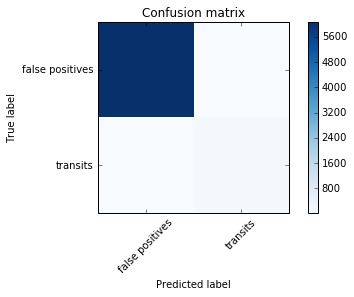

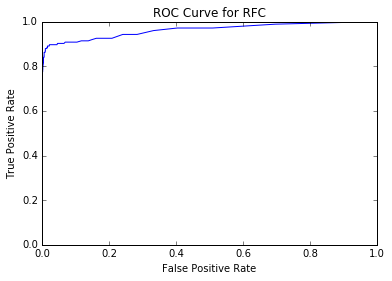

In [45]:
model=RandomForestClassifier(n_estimators=1000,class_weight={0:10,1:1},n_jobs=-1)
name="RFC"
fit(model,name,data,cv=False)

#####################################
Result using GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
f1 score from train test split 0.817391
roc score from train test split 0.950709
auc score from train test split 0.718775
[[6065   30]
 [  33  141]]


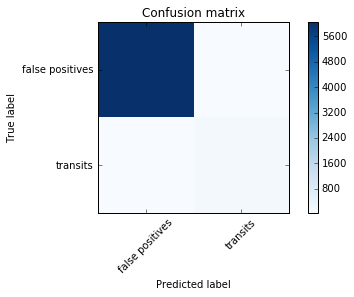

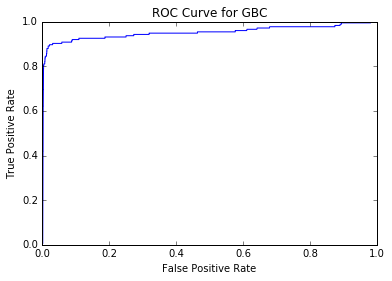

In [46]:
model=GradientBoostingClassifier(n_estimators=1000)
name="GBC"
fit(model,name,data,cv=False)

#####################################
Result using XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
f1 score from train test split 0.857143
roc score from train test split 0.951256
auc score from train test split 0.845125
[[6081   14]
 [  33  141]]


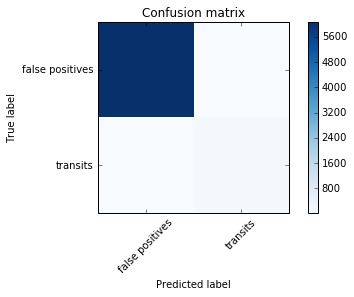

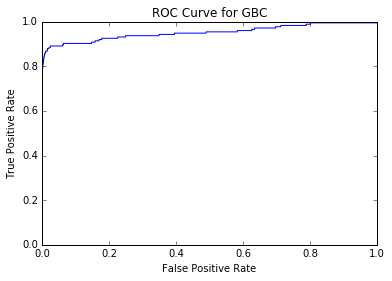

In [47]:
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=1000)
#model=XGBClassifier(learning_rate=0.1,
#    n_estimators=1000,
#    max_depth=5,
#    min_child_weight=1,
#    gamma=0,
#    subsample=0.8,
#    colsample_bytree=0.8,
#    objective='binary:logistic')
model.fit(trainX,trainY)
#model.plot_importance(bst)
#name="XGBoost"
fit(model,name,data,cv=False)

We can compare the prediction with the Manuel selection and the Catalog selection as the following: 

In [48]:
from sklearn.cross_validation import StratifiedKFold

model=RandomForestClassifier(n_estimators=3000,n_jobs=-1,class_weight='balanced_subsample',oob_score=True)

skf=StratifiedKFold(Y,n_folds=4)
i=1
for train_index,test_index in skf:
    trainX=X.iloc[train_index];testX=X.iloc[test_index]
    trainY=np.array(Y)[train_index];testY=np.array(Y)[test_index]
    #print train_index
    traincatY=np.array(df['CatalogY'])[train_index];testcatY=np.array(df['CatalogY'])[test_index]
    trainmanY=np.array(df['ManuleY'])[train_index];testmanY=np.array(df['ManuleY'])[test_index]
    model.fit(trainX,trainY)
    
    predY=model.predict_proba(testX)[:,1]
    rocscore = metrics.roc_auc_score(testY, predY)
    precision, recall, thresholds = metrics.precision_recall_curve(testY, predY)
    aucscore=metrics.auc(precision,recall,reorder=True)
    predY=model.predict(testX)
    f1score = metrics.f1_score(testY, predY)
    print "#####################################"
    print "fold %d:" % i
    print "f1 score from train test split %f" % f1score
    print "roc score from train test split %f" % rocscore
    print "auc score from train test split %f" % aucscore
    print "oob score from RF %f" % model.oob_score_
    
    flag1=(predY==1)*(predY==np.array(testY))

    flag2=(predY==1)*(predY==np.array(testmanY))
    
    print "predict Transit %d" % len(predY[predY==1])
    print "real Transit %d" % len(testY[testY==1])
    print "real Transit selected by eye %d" % len(testmanY[testmanY==1])
    print "predicted Transit that's real %d" % len(predY[flag1])
    print "predicted Transits selected by eye %d" % len(predY[flag2])
    i+=1

#####################################
fold 1:
f1 score from train test split 0.843823
roc score from train test split 0.958277
auc score from train test split 0.853169
oob score from RF 0.989875
predict Transit 196
real Transit 233
real Transit selected by eye 180
predicted Transit that's real 181
predicted Transits selected by eye 173
#####################################
fold 2:
f1 score from train test split 0.810427
roc score from train test split 0.943093
auc score from train test split 0.823545
oob score from RF 0.990684
predict Transit 189
real Transit 233
real Transit selected by eye 165
predicted Transit that's real 171
predicted Transits selected by eye 156
#####################################
fold 3:
f1 score from train test split 0.822695
roc score from train test split 0.954601
auc score from train test split 0.845070
oob score from RF 0.990173
predict Transit 190
real Transit 233
real Transit selected by eye 177
predicted Transit that's real 174
predicted Transits select

In [22]:
model=GradientBoostingClassifier(n_estimators=3000)

skf=StratifiedKFold(Y,n_folds=4)
i=1
for train_index,test_index in skf:
    trainX=X.iloc[train_index];testX=X.iloc[test_index]
    trainY=np.array(Y)[train_index];testY=np.array(Y)[test_index]
    #print train_index
    traincatY=np.array(df['CatalogY'])[train_index];testcatY=np.array(df['CatalogY'])[test_index]
    trainmanY=np.array(df['ManuleY'])[train_index];testmanY=np.array(df['ManuleY'])[test_index]
    model.fit(trainX,trainY)
    predY=model.predict(testX)
    f1score = metrics.f1_score(testY, predY)
    predY=model.predict_proba(testX)[:,1]
    rocscore = metrics.roc_auc_score(testY, predY)
    
    print "#####################################"
    print "fold %d:" % i
    print "f1 score from train test split %f" % f1score
    print "roc score from train test split %f" % rocscore
    
    flag1=(predY==1)*(predY==np.array(testY))

    flag2=(predY==1)*(predY==np.array(testmanY))
    
    print "predict Transit %d" % len(predY[predY==1])
    print "real Transit %d" % len(testY[testY==1])
    print "real Transit selected by eye %d" % len(testmanY[testmanY==1])
    print "predicted Transit that's real %d" % len(predY[flag1])
    print "predicted Transits selected by eye %d" % len(predY[flag2])
    i+=1

#####################################
fold 1:
f1 score from train test split 0.701031
roc score from train test split 0.973986
predict Transit 0
real Transit 51
real Transit selected by eye 21
predicted Transit that's real 0
predicted Transits selected by eye 0
#####################################
fold 2:
f1 score from train test split 0.733945
roc score from train test split 0.992892
predict Transit 0
real Transit 51
real Transit selected by eye 29
predicted Transit that's real 0
predicted Transits selected by eye 0
#####################################
fold 3:
f1 score from train test split 0.757282
roc score from train test split 0.994211
predict Transit 0
real Transit 51
real Transit selected by eye 25
predicted Transit that's real 0
predicted Transits selected by eye 0
#####################################
fold 4:
f1 score from train test split 0.528736
roc score from train test split 0.991854
predict Transit 0
real Transit 50
real Transit selected by eye 27
predicted Transit tha

In [23]:
model=XGBClassifier(n_estimators=3000)
#GradientBoostingClassifier(n_estimators=3000)

skf=StratifiedKFold(Y,n_folds=4)
i=1
for train_index,test_index in skf:
    trainX=X.iloc[train_index];testX=X.iloc[test_index]
    trainY=np.array(Y)[train_index];testY=np.array(Y)[test_index]
    #print train_index
    traincatY=np.array(df['CatalogY'])[train_index];testcatY=np.array(df['CatalogY'])[test_index]
    trainmanY=np.array(df['ManuleY'])[train_index];testmanY=np.array(df['ManuleY'])[test_index]
    model.fit(trainX,trainY)
    predY=model.predict(testX)
    f1score = metrics.f1_score(testY, predY)
    predY=model.predict_proba(testX)[:,1]
    rocscore = metrics.roc_auc_score(testY, predY)
    
    print "#####################################"
    print "fold %d:" % i
    print "f1 score from train test split %f" % f1score
    print "roc score from train test split %f" % rocscore
    
    flag1=(predY==1)*(predY==np.array(testY))

    flag2=(predY==1)*(predY==np.array(testmanY))
    
    print "predict Transit %d" % len(predY[predY==1])
    print "real Transit %d" % len(testY[testY==1])
    print "real Transit selected by eye %d" % len(testmanY[testmanY==1])
    print "predicted Transit that's real %d" % len(predY[flag1])
    print "predicted Transits selected by eye %d" % len(predY[flag2])
    i+=1

#####################################
fold 1:
f1 score from train test split 0.651685
roc score from train test split 0.973254
predict Transit 0
real Transit 51
real Transit selected by eye 21
predicted Transit that's real 0
predicted Transits selected by eye 0
#####################################
fold 2:
f1 score from train test split 0.702703
roc score from train test split 0.992267
predict Transit 0
real Transit 51
real Transit selected by eye 29
predicted Transit that's real 0
predicted Transits selected by eye 0
#####################################
fold 3:
f1 score from train test split 0.792453
roc score from train test split 0.986552
predict Transit 0
real Transit 51
real Transit selected by eye 25
predicted Transit that's real 0
predicted Transits selected by eye 0
#####################################
fold 4:
f1 score from train test split 0.597701
roc score from train test split 0.986818
predict Transit 0
real Transit 50
real Transit selected by eye 27
predicted Transit tha

### Feature Selection

In [17]:
featurelist=X.columns
rfc= RandomForestClassifier(n_estimators=1000)
rfc.fit(trainX, trainY)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [18]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
threshold=0.02
droplist=[]
for f in range(X.shape[1]):
    if importances[indices[f]]<threshold:
        droplist.append(featurelist[indices[f]])
    print("%d. feature %d (%s %f)" % (f + 1, indices[f], featurelist[indices[f]],importances[indices[f]]))

Feature ranking:
1. feature 4 (BLS_SDE_1_0 0.157572)
2. feature 19 (BLS_SignaltoPinknoise_1_0 0.141197)
3. feature 6 (BLS_Qtran_1_0 0.091206)
4. feature 11 (BLS_deltaChi2_1_0 0.089137)
5. feature 2 (BLS_SN_1_0 0.088532)
6. feature 13 (BLS_Npointsintransit_1_0 0.075070)
7. feature 16 (BLS_Npointsaftertransit_1_0 0.068895)
8. feature 7 (BLS_Qingress_1_0 0.052089)
9. feature 12 (BLS_fraconenight_1_0 0.033957)
10. feature 15 (BLS_Npointsbeforetransit_1_0 0.028787)
11. feature 5 (BLS_Depth_1_0 0.026279)
12. feature 0 (BLS_Period_1_0 0.025738)
13. feature 3 (BLS_SR_1_0 0.024792)
14. feature 18 (BLS_Whitenoise_1_0 0.016861)
15. feature 8 (BLS_OOTmag_1_0 0.016691)
16. feature 10 (BLS_i2_1_0 0.014491)
17. feature 9 (BLS_i1_1_0 0.013679)
18. feature 17 (BLS_Rednoise_1_0 0.013438)
19. feature 14 (BLS_Ntransits_1_0 0.012886)
20. feature 1 (BLS_Tc_1_0 0.008702)


In [19]:
X_selected=X.drop(droplist,axis=1)
X_selected.head()

,BLS_Period_1_0,BLS_SN_1_0,BLS_SR_1_0,BLS_SDE_1_0,BLS_Depth_1_0,BLS_Qtran_1_0,BLS_Qingress_1_0,BLS_deltaChi2_1_0,BLS_fraconenight_1_0,BLS_Npointsintransit_1_0,BLS_Npointsbeforetransit_1_0,BLS_Npointsaftertransit_1_0,BLS_SignaltoPinknoise_1_0
0,1.524372,4.80146,0.00062,5.33565,0.00567,0.01617,0.16729,-7.34176,0.15561,23.0,23.0,24.0,5.78138
1,2.528612,4.88453,0.00015,5.51377,0.00133,0.01640,0.15589,-1.14564,0.27827,24.0,24.0,24.0,6.28449
2,1.313471,4.27154,0.00029,4.55308,0.00262,0.01337,0.24601,-3.11193,0.36144,20.0,20.0,18.0,5.51545
3,4.337904,4.14879,0.00046,4.60567,0.00143,0.08733,0.03137,-1.25945,0.26322,128.0,111.0,127.0,4.01166
4,2.776622,4.30063,0.00007,4.54099,0.00024,0.10523,0.11883,-0.16030,0.16874,155.0,154.0,154.0,5.74249


#####################################
Result using RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
f1 score from train test split 0.832845
roc score from train test split 0.884637
f1 score from CV5 0.826780
[[6070   15]
 [  42  142]]


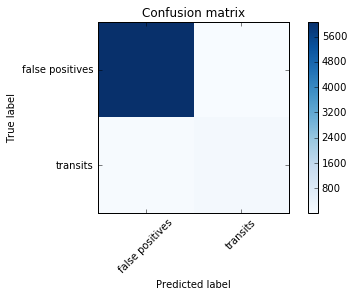

In [20]:
model=RandomForestClassifier(n_estimators=1000,n_jobs=-1,class_weight='balanced_subsample')
name="RFC"
fit(model,name,data)

## Tasks for Today: 
- optimize the models.
- lower the threshold of what is True in combinedY, and determine a limit of 0.7 f1 score.
- feature engerneering with unsupervised learning using the LC files. 
- More feature selection. 
- Try the larger data set if interested. 